# Project 4, APS1070 Fall 2024
#### **Linear Regression -  14 points**
**Deadline: Nov 29th, 23:00**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself without proper acknowledgment of the source, including generated code (please refer to the course syllabus). Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Your **name**: Xinyang Yan
*   Your **student number**: 1006777016

### How to submit **(HTML + IPYNB)**

1. Download your notebook: `File -> Download .ipynb`

2. Click on the Files icon on the far left menu of Colab

3. Select & upload your `.ipynb` file you just downloaded, and then obtain its path (right click) (you might need to hit the Refresh button before your file shows up)


4. execute the following in a Colab cell:
```
%%shell
jupyter nbconvert --to html /PATH/TO/YOUR/NOTEBOOKFILE.ipynb
```

5. An HTML version of your notebook will appear in the files, so you can download it.

6. Submit **both** <font color='red'>`HTML` and `IPYNB`</font>  files for this notebook on Quercus for grading.


Ref: https://stackoverflow.com/a/64487858

## Part 1 - Getting Started [2 marks]

In this project, we are going to design a mathematical model that predicts electrical grid stability, as described in the paper below:

*Schäfer, Benjamin, et al. 'Taming instabilities in power grid networks by decentralized control.' The European Physical Journal Special Topics 225.3 (2016): 569-582.*


For this purpose, we are using the [Electrical Grid Stability](https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data) dataset which includes 10000 instances with 12 features describing the power grid's status. The goal is to unravel patterns and predict the `stab` column, which is a characteristic of the grid that represents its stability. Note that you can ignore the last column named `stabf` since this is a binary indicator showing whether the stability is above a certain threshold.

In [119]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import scipy
from scipy.linalg import inv
import matplotlib.pyplot as plt

df = pd.read_csv(
    filepath_or_buffer="https://raw.githubusercontent.com/Sabaae/Dataset/main/electrical_grid_stability_simulated_data.csv",
    skipinitialspace=True
)

Here are the steps to complete this portion:

1. Print the dataframe.
2. Prepare your dataset as follows: **[1.5]**
*   Using `train_test_split` from Sklearn, split the dataset into training and validation sets ($80\%$ training, $20\%$ validation). When splitting, set `random_state=111`. **[0.5]**
*   Standardize the data **manually** according to the same method as `StandardScaler` from sklearn, but you may not directly use `StandardScaler'. **[0.5]**
*   Insert a first column of all $1$s in both the training and validation data sets.**[0.5]**
3. Explain why we should not insert the column of $1$s prior to standardization. **[0.5]**

In [120]:
# 1.1
print("Dataframe (first 5 rows):")
print(df.head())

Dataframe (first 5 rows):
       tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2  8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3  0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4  3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   

         p4        g1        g2        g3        g4      stab     stabf  
0 -1.723086  0.650456  0.859578  0.887445  0.958034  0.055347  unstable  
1 -1.255012  0.413441  0.862414  0.562139  0.781760 -0.005957    stable  
2 -0.920492  0.163041  0.766689  0.839444  0.109853  0.003471  unstable  
3 -0.997374  0.446209  0.976744  0.929381  0.362718  0.028871  unstable  
4 -0.554305  0.797110  0.455450  0.656947  0.820923  0.049860  unstable  


In [121]:
# 1.2
X = df.drop(columns=['stab','stabf'], axis=1) 
y = df['stab'] 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=111)
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train_standardized = (X_train - X_train_mean) / X_train_std
X_val_standardized = (X_val - X_train_mean) / X_train_std

In [122]:
X_train_standardized.insert(0, 'ones', 1)
X_val_standardized.insert(0, 'ones', 1)
print("Training Data (first 5 rows):")
print(X_train_standardized.head())
print("Validation Data (first 5 rows):")
print(X_val_standardized.head())

Training Data (first 5 rows):
      ones      tau1      tau2      tau3      tau4        p1        p2  \
27       1 -1.660528  0.430695  0.377521 -1.626030 -1.104238  0.140792   
3847     1  1.661669  0.157388  0.907843 -0.057686 -1.233902  1.424940   
7461     1  0.566266 -1.409389 -0.765733 -0.022768  1.619815 -0.657975   
1356     1  0.817639  1.390610 -0.220468  1.042713 -0.253103  1.444321   
4314     1  1.465225 -0.803014 -1.677004  0.085506  0.294031 -0.758831   

            p3        p4        g1        g2        g3        g4  
27    1.294721  0.485867 -0.183690 -1.699643 -1.112068  0.444101  
3847  0.437191  0.280368  0.793566 -1.204491  0.272084 -0.450099  
7461 -1.229423 -0.930051  1.400131 -1.373953  0.370590 -1.736786  
1356  0.390866 -1.402009  1.424291  0.754523  0.272588  1.577516  
4314 -1.404023  1.656764  0.327629 -0.970964  0.294281 -0.945189  
Validation Data (first 5 rows):
      ones      tau1      tau2      tau3      tau4        p1        p2  \
207      1 -1.524

# 1.3
We should not insert the column of 1s prior to standardization because the purpose of standardization is to
scale the features to have mean 0 and variance 1. If we include the column of 1s during standardization, it
will result in incorrect scaling of that column, which is meant to represent a constant bias term in the
model. By standardizing only the original features first and then adding the column of 1s, we ensure that
the bias term remains unaffected and serves its intended purpose in the regression model.

## Part 2 - Linear Regression Using Direct Solution [1 marks]

Implement the direct solution of the linear regression problem on the training set. **[0.5]**

**Note: You should use scipy.linalg.inv to perform the inversion, as numpy.linalg.inv may cause an error.**

Report the root-mean-square error (RMSE) for both the training and validation sets. **[0.5]**

You may use `root_mean_squared_error` from Sklearn for computing the RMSE.

In [123]:
X_train_array = X_train_standardized.values
X_val_array = X_val_standardized.values  
y_train_array = np.array(y_train).reshape(-1, 1)  
y_val_array = np.array(y_val).reshape(-1, 1)  

W = np.dot(scipy.linalg.inv(np.dot(X_train_array.T, X_train_array)), np.dot(X_train_array.T, y_train_array))
yPred_train = np.dot(X_train_array, W)
yPred_val = np.dot(X_val_array, W)

rmse_train = np.sqrt(mean_squared_error(yPred_train, y_train))
rmse_val = np.sqrt(mean_squared_error(yPred_val, y_val))

print(f"Training RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_val}")

Training RMSE: 0.021988385118113213
Validation RMSE: 0.021858035187013927


## Part 3 - Full Batch Gradient Descent [4 marks]

We will now implement a "full batch" gradient descent algorithm and record the training time for our model. Recall that the full batch gradient descent is,
 $$w_t = w_{t-1} - \alpha~g_t$$ where $\alpha$ is the learning rate and $g_t$ is your gradient, computed on the entire data.

Here are the steps for this part:

* Implement gradient descent for linear regression using a fixed learning rate of $\alpha= 0.01$, and iterate until your model's **validation** RMSE converges.

  We consider the gradient descent as having converged when RMSE on the validation set using gradient descent satisfies:

  $$ RMSE_\text{GD} \leq 1.0005 \times RMSE_\text{Direct Solution}$$

  where $RMSE_\text{Direct Solution}$ is the RMSE on the validation set using the direct solution that you calculated in the previous part.

  We refer to the quantity $RMSE_\text{Direct Solution}\times 1.0005$ as the convergence threshold (CT).
  Be sure to compute the gradients yourself! Take a look at the code provided in the tutorial. **[1]**

*  Record the training time (from the first iteration until convergence) using the `time.time()` function. **[0.5]**

* Plot the training RMSE and the validation RMSE vs. epoch on the same figure.  **[1]**

* Comment on overfitting/underfitting by observing the training and validation RMSE **[1]**

    **Hint**: Initialize your weights with small random numbers (<$0.00001$) & please set **np.random.seed(1001)**

* Explain the difference between epoch and iteration in the Gradient descent algorithm (SGD/mini-batch)? **[0.5]**

In [124]:
np.random.seed(1001)
alpha = 0.01
max_epochs = 10000
convergence_threshold = rmse_val * 1.0005
W = (np.random.random(X_train_standardized.shape[1]) / 100000).reshape(1, -1).T
epoch = 0
train_rmse_list = []
val_rmse_list = []
start_time = time.time()

In [125]:
while True:
    yPred_train = np.dot(X_train_array, W)
    yPred_val = np.dot(X_val_array, W)

    rmse_train_gd = np.sqrt(mean_squared_error(yPred_train, y_train))
    rmse_val_gd = np.sqrt(mean_squared_error(yPred_val, y_val))

    train_rmse_list.append(rmse_train_gd)
    val_rmse_list.append(rmse_val_gd)

    if rmse_val_gd <= convergence_threshold or epoch >= max_epochs:
        break
    gradient = (1 / X_train_array.shape[0]) * np.dot(X_train_array.T, (yPred_train - y_train_array))
    W = W - alpha * gradient

    epoch += 1
print("--- Total Training Time: %s (s) ---" % (time.time() - start_time))
print('Converged Epochs:', len(val_rmse_list))
print("Final Training RMSE:" ,train_rmse_list[-1])
print("Final Validation RMSE:",val_rmse_list[-1])


--- Total Training Time: 0.16685700416564941 (s) ---
Converged Epochs: 318
Final Training RMSE: 0.02200384061052233
Final Validation RMSE: 0.021868938906049722


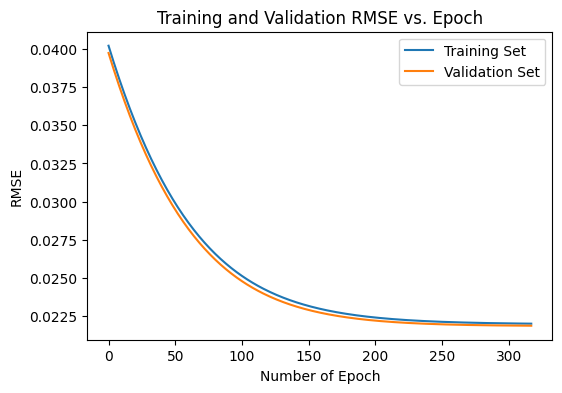

In [126]:
# Plot training and validation RMSE vs. epoch
plt.figure(figsize=(6, 4))
plt.plot(range(len(train_rmse_list)), train_rmse_list, label='Training Set')
plt.plot(range(len(val_rmse_list)), val_rmse_list, label='Validation Set')
plt.xlabel('Number of Epoch')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE vs. Epoch')
plt.legend()
plt.show()


Both training RMSE (blue line) and validation RMSE (orange line) are decreasing steadily over the epochs. The lines are very close to each other and decrease at a similar rate, which suggests that the model is learning well without overfitting or underfitting. Both curves decrease steadily over the epochs and converge at similar values, demonstrating that the model generalizes well to unseen data without memorizing the training set excessively. 

In gradient descent, an epoch refers to one complete pass over the entire training dataset, whereas an iteration is a single update of model parameters. For stochastic gradient descent (SGD) or mini-batch gradient descent, multiple iterations occur within each epoch, as the model parameters are updated for every batch or data point rather than waiting for a complete pass through the dataset.

## Part 4 - Mini-batch and Stochastic Gradient Descent [4 marks]

Write a function that performs mini-batch gradient descent until the convergence threshold (CT) is reached. **[1]**

The inputs of that function are:
  * Input data (training/validation), Batch size, Learning Rate, Convergence Threshold (CT)

Your function will return the following arrays:
 * The final weights after training.
 * The training RMSE at each epoch.
 * The validation RMSE at each epoch.
 * An array that has the elapsed time from the start of the training process to the end of each epoch (e.g., if each epoch takes exactly 2 seconds, the array would look like: [2 4 6 8 ...]).

Notes:
* use **np.random.seed(1001)** before setting the initial (random) weights

  ```
  def mini_batch_gd(YOUR_INPUTS):
    np.random.seed(1001)

    ### YOUR CODE HERE ###
    
    return YOUR_OUTPUTS
  ```

* For certain batch sizes, GD might not converge to a solution. For that reason, you need to check the RMSE of the validation/training set at each epoch, and if it's getting larger and larger, you should stop the training for that case (the design is up to you!).
* CT will help you to know when your model is converged.
* **Important: after each epoch, you need to shuffle the entire training set.** This ensures that new mini-batches are selected for every epoch. Hint: use `np.random.permutation`.

Let's now use the function to investigate the effect of batch size on convergence. When the batch size is 1, we call that stochastic gradient descent. When the batch size equals the # of training data, it is full-batch (i.e., all data points are used at every iteration). Anywhere in between is mini-batch (we use some of the data).
  * Sweep different values for the mini-batch size (at least 5 values that **converge**), each time using a learning rate of $\alpha= 0.01$. **Hint: Try batch sizes that are powers of two (e.g., 2,4,8,16,...).** These batch sizes fit better on the hardware and may achieve higher performance.  **[0.5]**

Provide the following $3$ plots:
  1.  Plot training and validation RMSE vs. **epoch** for all the **converging** batch sizes (some batch sizes might not converge) in a figure. The X-axis is Epoch # and the Y-axis is RMSE. **[0.5]**
  2. Plot training and validation RMSE vs. **time** for all the **converging** batch sizes in a figure. The X-axis is Time, and the Y-axis is RMSE. **[0.5]**
  3. Plot Total training time (y-axis) vs. Batch size (x-axis). **[0.5]**

Describe your findings, including the main takeaways from each of your plots. **[1]**

In [127]:
def mini_batch_gd(X_train, y_train, X_val, y_val, batch_size, learning_rate, convergence_threshold, max_epochs=10000, early_stop_ct=3.5):
    np.random.seed(1001)
    num_samples = X_train.shape[0]
    num_features = X_train.shape[1]

    w = (np.random.randn(num_features) * 1e-5).reshape(-1, 1)
    train_rmse_list = []
    val_rmse_list = []
    elapsed_time_list = []
    start_time = time.time()
    epoch = 0
    early_stop_counter = 0

    while epoch < max_epochs:
        permutation = np.random.permutation(num_samples)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        for i in range(0, num_samples, batch_size):
            X_batch = X_train_shuffled[i:i + batch_size]
            y_batch = y_train_shuffled[i:i + batch_size]

            y_pred_batch = np.dot(X_batch, w)
            gradient = (1 / X_batch.shape[0]) * np.dot(X_batch.T, (y_pred_batch - y_batch))
            w = w - learning_rate * gradient

        y_train_pred = np.dot(X_train, w)
        y_val_pred = np.dot(X_val, w)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

        train_rmse_list.append(rmse_train)
        val_rmse_list.append(rmse_val)
        elapsed_time_list.append(time.time() - start_time)

        if rmse_val <= convergence_threshold:
            print(f"Converged batch size: {batch_size}\nEpoch number: {epoch + 1}")
            break

        if len(val_rmse_list) > 1 and val_rmse_list[-1] > val_rmse_list[-2]:
            early_stop_counter += 1
        else:
            early_stop_counter = 0

        if early_stop_counter >= early_stop_ct:
            print(f"Early stopping triggered after {epoch + 1} epochs with batch size = {batch_size}")
            break

        epoch += 1

    return w, train_rmse_list, val_rmse_list, elapsed_time_list


batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
learning_rate = 0.01

for batch_size in batch_sizes:
    w, train_rmse_list, val_rmse_list, elapsed_time_list = mini_batch_gd(X_train_array, y_train_array, X_val_array, y_val_array, batch_size, learning_rate, convergence_threshold)

Early stopping triggered after 138 epochs with batch size = 1
Early stopping triggered after 137 epochs with batch size = 2
Early stopping triggered after 58 epochs with batch size = 4
Converged batch size: 8
Epoch number: 27
Converged batch size: 16
Epoch number: 1
Converged batch size: 32
Epoch number: 2
Converged batch size: 64
Epoch number: 3
Converged batch size: 128
Epoch number: 6
Converged batch size: 256
Epoch number: 10
Converged batch size: 512
Epoch number: 20
Converged batch size: 1024
Epoch number: 40


Converged batch size: 8
Epoch number: 27
Converged batch size: 16
Epoch number: 1
Converged batch size: 32
Epoch number: 2
Converged batch size: 64
Epoch number: 3
Converged batch size: 128
Epoch number: 6
Converged batch size: 256
Epoch number: 10
Converged batch size: 512
Epoch number: 20


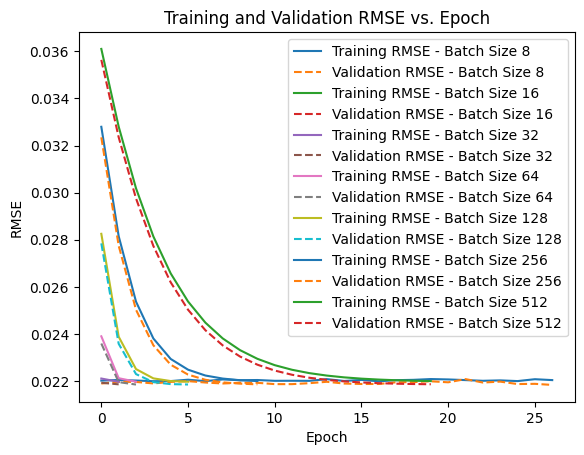

In [128]:
batch_sizes = [8, 16, 32, 64, 128, 256, 512]
learning_rate = 0.01

for i in batch_sizes:
    w, train_rmse_list, val_rmse_list, elapsed_time_list = mini_batch_gd(X_train_array, y_train_array, X_val_array, y_val_array, i, learning_rate, convergence_threshold)

    plt.plot(range(len(train_rmse_list)), train_rmse_list, label=f'Training RMSE - Batch Size {i}')
    plt.plot(range(len(val_rmse_list)), val_rmse_list, linestyle='--', label=f'Validation RMSE - Batch Size {i}')

plt.title('Training and Validation RMSE vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()


Converged batch size: 8
Epoch number: 27
Converged batch size: 16
Epoch number: 1
Converged batch size: 32
Epoch number: 2
Converged batch size: 64
Epoch number: 3
Converged batch size: 128
Epoch number: 6
Converged batch size: 256
Epoch number: 10
Converged batch size: 512
Epoch number: 20


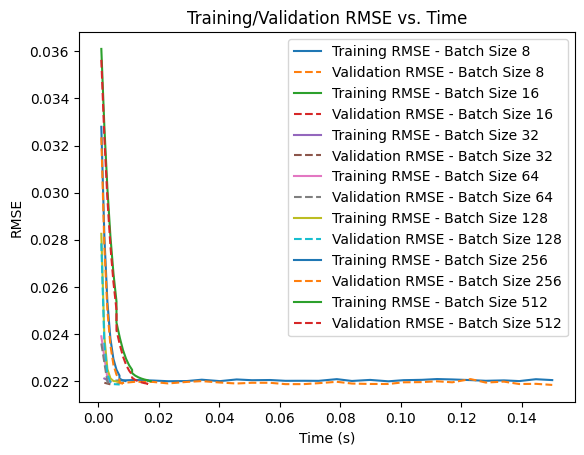

In [129]:
#RMSE vs. time
for i in batch_sizes:
    w, train_rmse_list, val_rmse_list, elapsed_time_list = mini_batch_gd(X_train_array, y_train_array, X_val_array, y_val_array, i, learning_rate, convergence_threshold)

    plt.title('Training/Validation RMSE vs. Time')
    plt.plot(elapsed_time_list, train_rmse_list, label=f'Training RMSE - Batch Size {i}')
    plt.plot(elapsed_time_list, val_rmse_list, linestyle='--', label=f'Validation RMSE - Batch Size {i}')
    plt.xlabel('Time (s)')
    plt.ylabel('RMSE')
    plt.legend()

plt.show()

Converged batch size: 8
Epoch number: 27
Converged batch size: 16
Epoch number: 1
Converged batch size: 32
Epoch number: 2
Converged batch size: 64
Epoch number: 3
Converged batch size: 128
Epoch number: 6
Converged batch size: 256
Epoch number: 10
Converged batch size: 512
Epoch number: 20


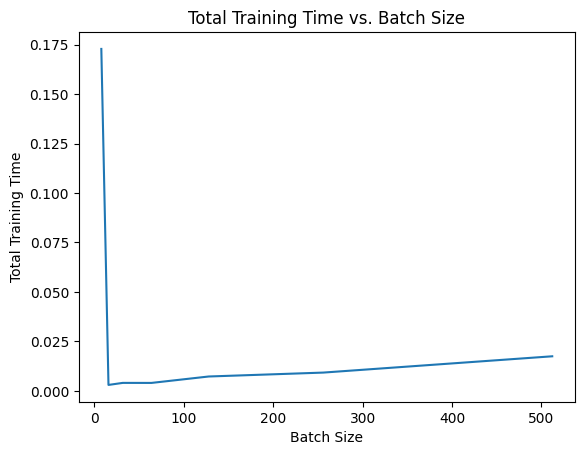

In [130]:
total_time = []

for i in batch_sizes:
  w, train_rmse_list, val_rmse_list, elapsed_time_list = mini_batch_gd(X_train_array, y_train_array, X_val_array, y_val_array, i, learning_rate, convergence_threshold)
  total_time.append(elapsed_time_list[-1])

plt.title('Total Training Time vs. Batch Size')
plt.plot(batch_sizes, total_time) 
plt.xlabel('Batch Size')
plt.ylabel('Total Training Time')
plt.show()

The analysis reveals that smaller batch sizes, such as 16 and 32, lead to faster convergence in terms of both epochs and total training time compared to larger batch sizes. These smaller batch sizes benefit from more frequent parameter updates, allowing the model to converge quickly. Larger batch sizes, on the other hand, provide more stable updates but require significantly longer training times to achieve similar RMSE. The balance between convergence speed and stability is best achieved with moderate batch sizes, which optimize both learning efficiency and computational cost.

## Part 5 - Gradient Descent Learning Rate [3 marks]
Use the function that you designed in Part 4 to investigate the effect of learning rate on convergence.

1. Pick 3 batch sizes that do not converge with a learning rate of $\alpha= 0.01$ (last part) and try to find a learning rate that results in convergence for each batch size. Report your findings in a table. Mention batch size, learning rate, and training and validation RMSE. **[1]**

2. Select the best batch size based on Part 4's fastest convergence time and sweep the learning rate (at least 10 values, all should converge) while applying Mini-batch GD.
  
  * Plot the training and validation RMSE vs. **epoch** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  * Plot the training and validation RMSE vs. **time** (x-axis) for all the learning rates that you tried in a figure. **[0.5]**
  * Describe your findings, including the main takeaways from each of your plots. **[1]**

In [131]:
def mini_batch_gd5(X_train, y_train, X_val, y_val, batch_size, lr, ct):
    np.random.seed(1001)
    w = (np.random.random(X_train.shape[1]) / 100000).reshape(1, -1)
    rmse_train_array, rmse_val_array, epoch_time = [], [], []
    consecutive_increase, n_epoch = 0, 0
    start_time = time.time()
  
    while True:
        n_epoch += 1
        permutation = list(np.random.permutation(X_train.shape[0]))
        X_train, y_train = X_train[permutation], y_train[permutation]
        n_batches = int(np.ceil(X_train.shape[0] / batch_size))
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, X_train.shape[0])
            X_train_batch = X_train[start_idx:end_idx]
            y_train_batch = y_train[start_idx:end_idx]
            yPred_batch = np.dot(X_train_batch, w.T)
            gradient = (1 / len(yPred_batch) * np.dot(X_train_batch.T, yPred_batch - y_train_batch)).reshape(1, -1)
            w = w - lr * gradient

        yPred_train = np.dot(X_train, w.T)
        yPred_val = np.dot(X_val, w.T)

        rmse_train_cur = np.sqrt(mean_squared_error(yPred_train, y_train))
        rmse_val_cur = np.sqrt(mean_squared_error(yPred_val, y_val))

        rmse_train_array.append(rmse_train_cur)
        rmse_val_array.append(rmse_val_cur)
        epoch_time.append(time.time() - start_time)
        
        if (epoch > 800 and batch_size < 8) or (epoch > 3000 and batch_size > 4):
            print('Not Converge: ','Batch_size =', batch_size, ', Learning rate=', lr)
            break
        if(rmse_val_array[-1] <= ct):
            print('Converged: ', 'Batch size =', batch_size, ', Learning rate=', lr, 'Poch number:', epoch)
            break

    return w, rmse_train_array, rmse_val_array, epoch_time



In [132]:
alpha = [0.001, 0.009, 0.0115, 0.015, 0.009, 0.022, 0.0255, 0.029, 0.0325, 0.05, 0.0001, 0.0005]
batch_sizes = [1, 2, 4]
ct = rmse_val * 1.0005 
result = []


for bs in batch_sizes:
  for lr in alpha:
    w, rmse_train_array, rmse_val_array, epoch_time = mini_batch_gd5(X_train_array, y_train_array, X_val_array, y_val_array, bs, lr, ct)
    if rmse_val_array[-1] <= ct: 
      result.append([bs, lr, rmse_train_array[-1], rmse_val_array[-1]])
      break    

df_result = pd.DataFrame(result, columns=["Batch Size","Learning Rate","Training RMSE", "Validation RMSE"])

Converged:  Batch size = 1 , Learning rate= 0.001 Poch number: 317
Converged:  Batch size = 2 , Learning rate= 0.001 Poch number: 317
Converged:  Batch size = 4 , Learning rate= 0.001 Poch number: 317


In [133]:
df_result

,Batch Size,Learning Rate,Training RMSE,Validation RMSE
0,1,0.001,0.021993,0.021856
1,2,0.001,0.021978,0.021828
2,4,0.001,0.021972,0.021827


In [134]:
lr = 0.01
ct = rmse_val * 1.0005 
batch_size = [16, 32, 64]
total_time = []

for i in batch_size:
  w, rmse_train_array, rmse_val_array, epoch_time = mini_batch_gd(X_train_array, y_train_array, X_val_array, y_val_array, i, lr, ct)
  total_time.append(epoch_time[-1])

print(total_time)
mini_index = total_time.index(min(total_time))
best_batch_size = batch_size[mini_index]
print('Best batch size based on part 4: ', best_batch_size)

Converged batch size: 16
Epoch number: 1
Converged batch size: 32
Epoch number: 2
Converged batch size: 64
Epoch number: 3
[0.004301548004150391, 0.005120992660522461, 0.0051343441009521484]
Best batch size based on part 4:  16


Converged batch size: 16
Epoch number: 7
Converged batch size: 16
Epoch number: 2
Converged batch size: 16
Epoch number: 1
Converged batch size: 16
Epoch number: 1
Converged batch size: 16
Epoch number: 11
Converged batch size: 16
Epoch number: 11
Converged batch size: 16
Epoch number: 27
Converged batch size: 16
Epoch number: 27
Converged batch size: 16
Epoch number: 27
Converged batch size: 16
Epoch number: 27


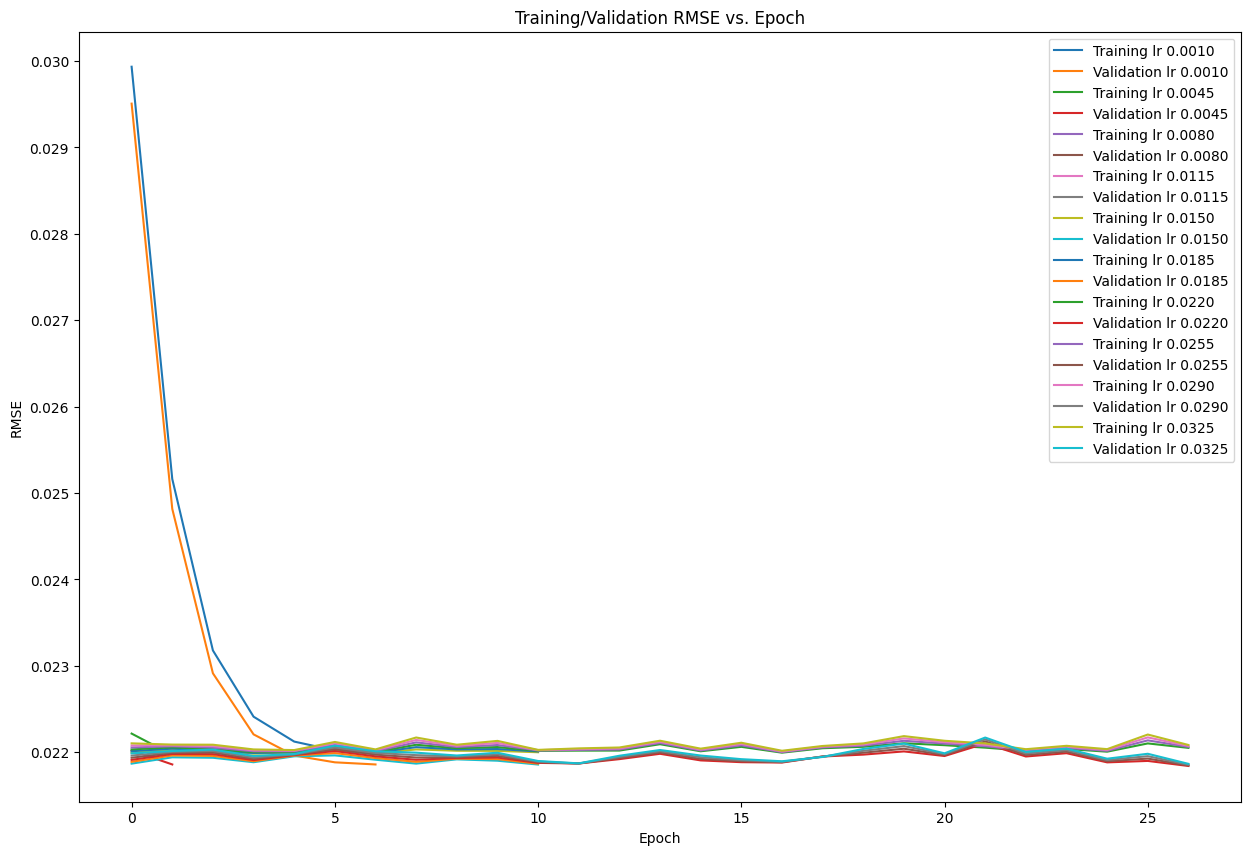

In [135]:
#plot 1: training and validation RMSE vs. epoch with different learning rate
learning_rate = np.linspace(0.001,0.05,15)
ct = rmse_val * 1.0005 
batch_size = best_batch_size

plt.figure(figsize=(15,10))

for i in range(10):
  w, rmse_train_array, rmse_val_array, epoch_time = mini_batch_gd(X_train_array, y_train_array, X_val_array, y_val_array, batch_size, learning_rate[i], ct)

  plt.title('Training/Validation RMSE vs. Epoch')
  plt.plot(range(len(rmse_train_array)), rmse_train_array, label = 'Training lr {:.4f}'.format(learning_rate[i])) 
  plt.plot(range(len(rmse_val_array)), rmse_val_array, label = 'Validation lr {:.4f}'.format(learning_rate[i])) 
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.legend()

Converged batch size: 16
Epoch number: 7
Converged batch size: 16
Epoch number: 2
Converged batch size: 16
Epoch number: 1
Converged batch size: 16
Epoch number: 1
Converged batch size: 16
Epoch number: 11
Converged batch size: 16
Epoch number: 11
Converged batch size: 16
Epoch number: 27
Converged batch size: 16
Epoch number: 27
Converged batch size: 16
Epoch number: 27
Converged batch size: 16
Epoch number: 27


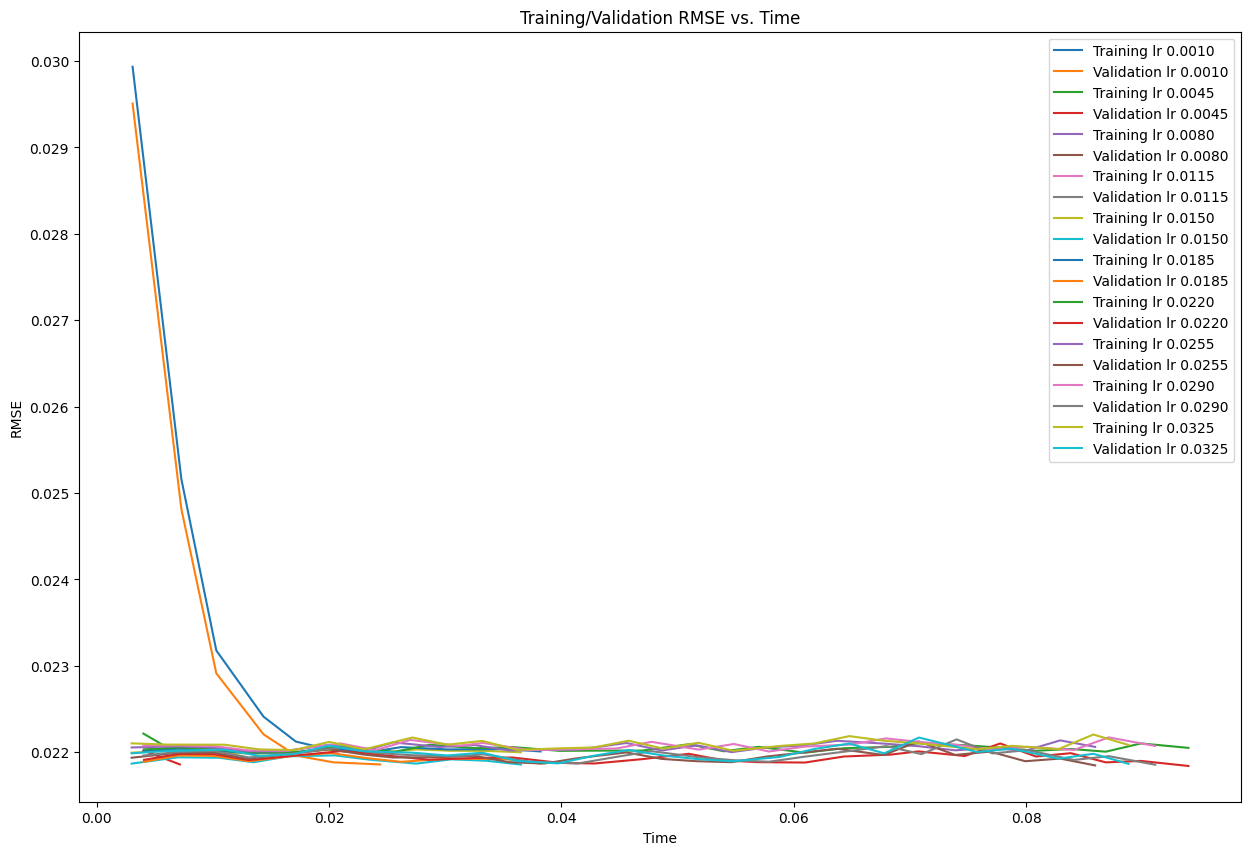

In [136]:
# plot 2: training and validation RMSE vs. time (x-axis)
learning_rate = np.linspace(0.001,0.05,15)
ct = rmse_val * 1.0005 
batch_size = best_batch_size

plt.figure(figsize=(15,10))

for i in range(10):
  w, rmse_train_array, rmse_val_array, epoch_time = mini_batch_gd(X_train_array, y_train_array, X_val_array, y_val_array, batch_size, learning_rate[i], ct)

  plt.title('Training/Validation RMSE vs. Time')
  plt.plot(epoch_time, rmse_train_array, label = 'Training lr {:.4f}'.format(learning_rate[i])) 
  plt.plot(epoch_time, rmse_val_array, label = 'Validation lr {:.4f}'.format(learning_rate[i]))  
  plt.xlabel('Time')
  plt.ylabel('RMSE')
  plt.legend()

The results indicate that higher learning rates lead to faster initial convergence but may be less stable. Lower learning rates provide a more stable convergence, though they require more epochs to reach optimal RMSE. It is crucial to find a balance between convergence speed and stability to achieve the best model performance with minimal computational cost.
